<table><tr>
<td> <img src="../../images/URV.png" style="width: 250px;"/> </td>
<td> <img src="../../images/UOC.jpg" style="width: 250px;"/> </td>
</tr></table>

# Descriptive sentiment analysis for all cryptocurrencies

The objective of this notebook is to describe and have a general idea of how Twitter sentiments have an effect on cryptos. 

### Import libraries

In [1]:
# Import psycopg2 for creating and manipulating SQL databases
import psycopg2

# Import pandas for dataframe manipulation
import pandas as pd

# Import matplotlib and seaborn for data visualization
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
%matplotlib inline

plt.rcParams["figure.figsize"] = (16,10)
import seaborn as sns

# Import re for regular expressions' wrangling
import re

# Import Login_access for logging in in our DB
from Login_access import host, port, user, password

### Connect to database

In [2]:
# Connect to DB with credentials
conn = psycopg2.connect(host=host, database="TwitterDB", port=port, user=user, password=password)

# Create the cursor to execute SQL commands
cur = conn.cursor()

# Declare the SQL sentence
command = "SELECT * FROM crypto_table;"

# Execute the SQL command
cur.execute(command)
            
# Save execution into a variable
df = pd.DataFrame(cur.fetchall())
df.columns=[ col.name for col in cur.description]

# Some statistics

## Number of tweets for each crypto

The first descriptive graph we preceed to draw is a bar plot with the number of tweets for each crypto. As long as any tweet contains their full name (e.g. bitcoin), or their symbol (e.g. BTC), they will be added to the sum. Note that some tweets may be counted more than once as they can talk about more that one crypto at a time.

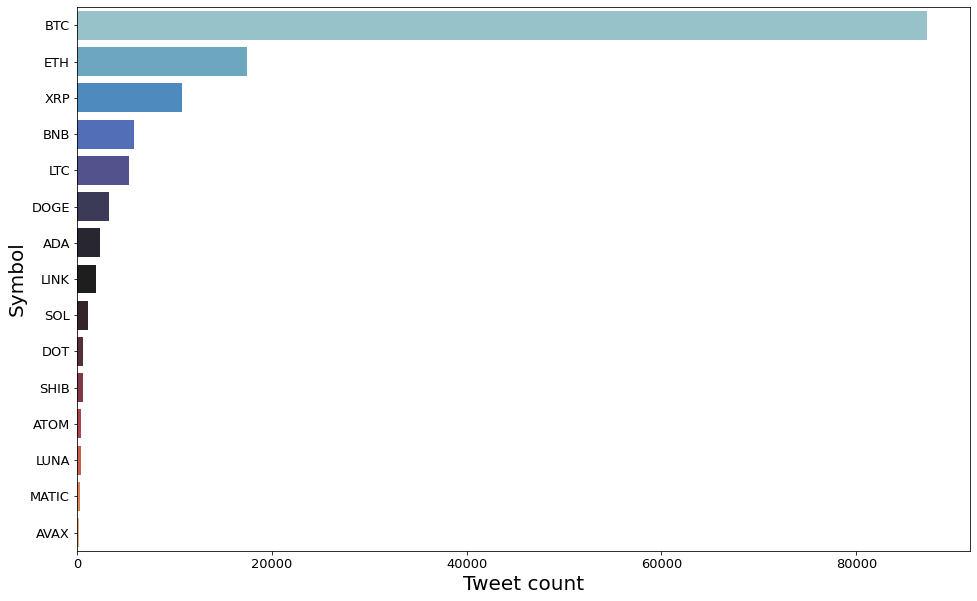

In [3]:
# Counting the number of tweets for each crypto
count = df.groupby('symbol')['tweet_id'].count().reset_index().sort_values(by = 'tweet_id', ascending = False)

# Plotting results
sns.barplot(x='tweet_id', y='symbol', data=count, palette="icefire")
plt.xlabel("Tweet count", fontsize=20)
plt.ylabel("Symbol", fontsize=20)
plt.show();

As we can observe, a huge number of all those tweets mention the bitcoin or BTC word. 

Although not fully aligned with their market capitalization (as of 2021), this graph truly represents a proxy of the market purchasing habits, since bitcoin and ethereum are on the top positions and the following ones generally do have more market capitalization than the bottom ones.

## What other cryptos do people talk when they talk about ...

When people talk about any crypto they often mention another one of them. For example, someone might express that "Both BTC and ETH are experiencing high volatility at this time". In this case we could argue that ethereum has been referenced in a bitcoin tweet, or viceversa.

The following lines of code aim at assessing the number of references made to other crypto for each group of cryptos.

In [4]:
# Create an empty DF that will contain all of our data
container = pd.DataFrame(columns = ['symbol', 'others'])

# Generate a loop for each symbol
for symbol in df.symbol.unique().tolist():
    
    # All tweets that talk about a specific crypto
    left = df[df['symbol'] == symbol][['tweet_id', 'symbol']].reset_index()

    # All the other tweets that DO NOT talk about the before-mentioned crypto
    right = df[df['symbol'] != symbol][['tweet_id', 'symbol']]

    # Merge both DFs to see if there are commom tweets
    merge = left.merge(right, on='tweet_id', how='left').dropna(axis = 0)

    # Create a DF that will store all tweets in common
    tmp = pd.DataFrame(merge[['symbol_x', 'symbol_y']])\
                                 .rename({'symbol_x': 'symbol', 'symbol_y': 'others'}, axis=1)

    # Unite the DF from before with the container of data
    container = pd.concat([container, tmp])

# When the container is full, crosstab to know the % of other cryptos discussed
container = pd.crosstab(index=container['symbol'], columns=container['others'], normalize="index")

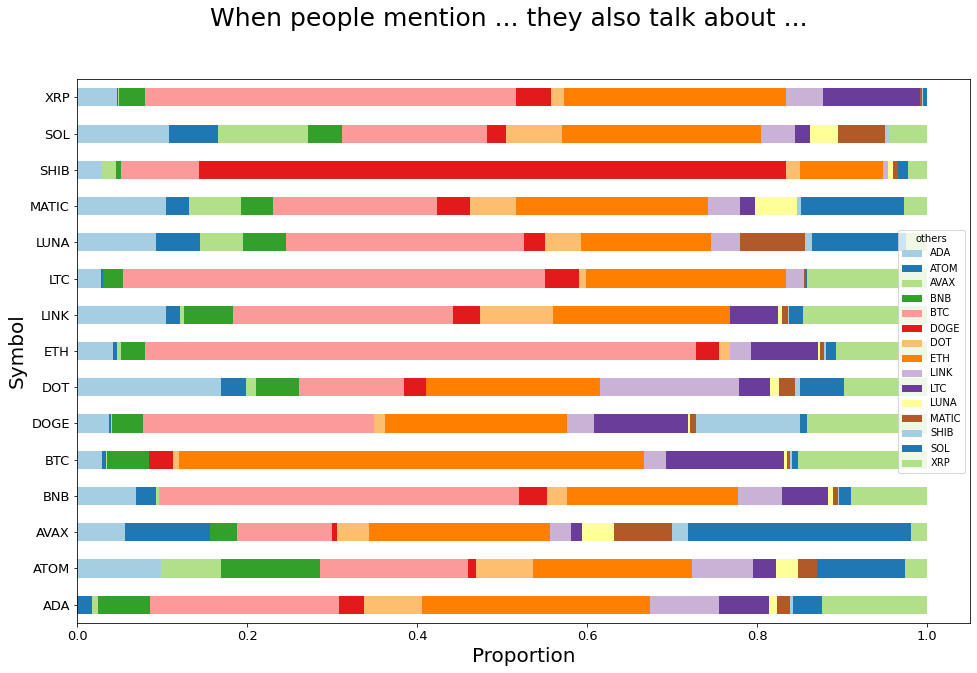

In [5]:
# Plotting results
customPalette = sns.set_palette(sns.color_palette("Paired", 15))
container.plot(kind = 'barh', stacked = True, colormap = customPalette)
plt.suptitle('When people mention ... they also talk about ...', fontsize=25)
plt.xlabel("Proportion", fontsize=20)
plt.ylabel("Symbol", fontsize=20)
plt.show();

As a general rule of thumb, bitcoin is the most referenced coin when people talk about any other crypto. However, note that there are some othere corrlations among coins that must be pointed out. For example, When people write about shiba inu, the most referenced coin is dogecoin, and when people talk about bitcoin, more than half the references are directed to ethereum. This is mainly due to the fact that these are especially correlated among each other.

## Sentiment perception for each crypto

### Positive, neutral and negative analysis

When writing about a cryptocurrencies, do people talk positively or negatively? We will find out by plotting the % of positive, neutral and negative tweets for each crypto.

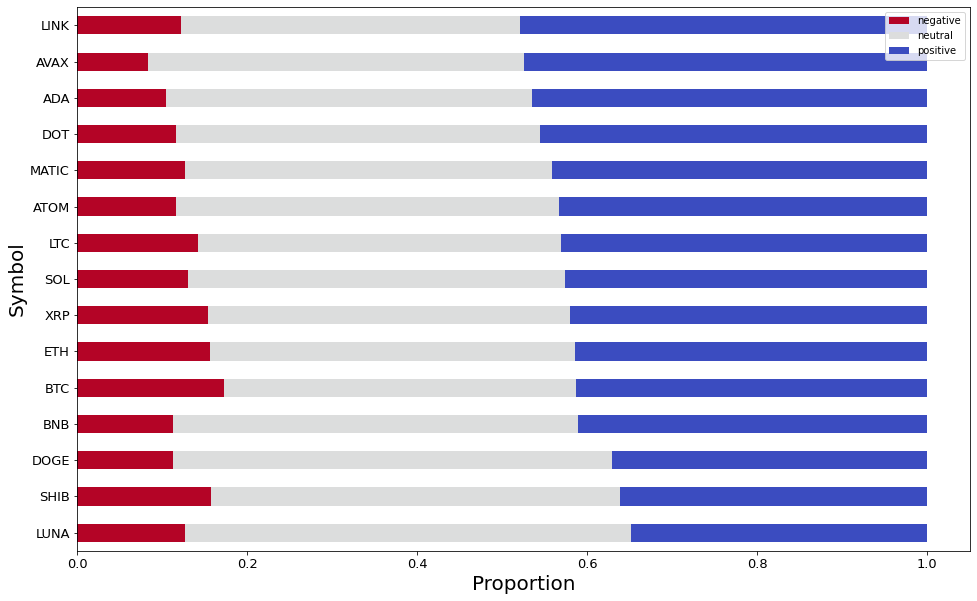

In [6]:
cross_tab = pd.crosstab(index=df['symbol'], columns=df['outcome'], normalize="index").sort_values('positive')

cross_tab.plot(kind='barh', stacked=True, colormap='coolwarm_r')

plt.legend(loc="upper right", ncol=1)
plt.xlabel("Proportion", fontsize=20)
plt.ylabel("Symbol", fontsize=20)
plt.show()

As we can see from the graph, there seems to be a similar % of positive and negative tweets for each crypto. AVAX takes the win with the least negative comments and a sufficiently large proportion of positive tweets, whereas SHIB does have quite an unpopular opinion on the social platform and a relatively low proportion of positive comments. In the following lines we will plot the sentiment score in boxplots to get a more in-depth study of the sentiment scores.

### Sentiment score distribution

After reviewing the % of sentiment allocated to each crypto is time to analyze the distribution of their sentiment scores.

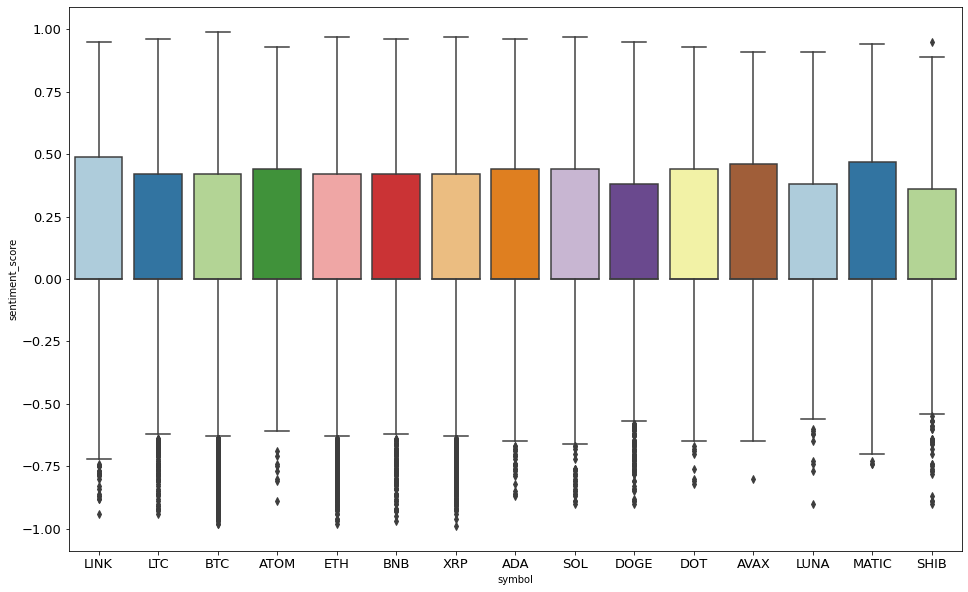

In [7]:
df['sentiment_score'] = [float(x) for x in df['sentiment_score']]

sns.boxplot(x="symbol", y="sentiment_score", data=df);

The first thing that comes to our mind when we see this graph is the perfect alignment of the 25% percentile with the 0 score. Exploring further into the issue, we plot the bitcoin histogram and find out that there is a really high density of tweets scoring 0 in the model. Because of that, it makes sense that the tweet that makes the 25th percent of the sample most probably has a score of 0. 

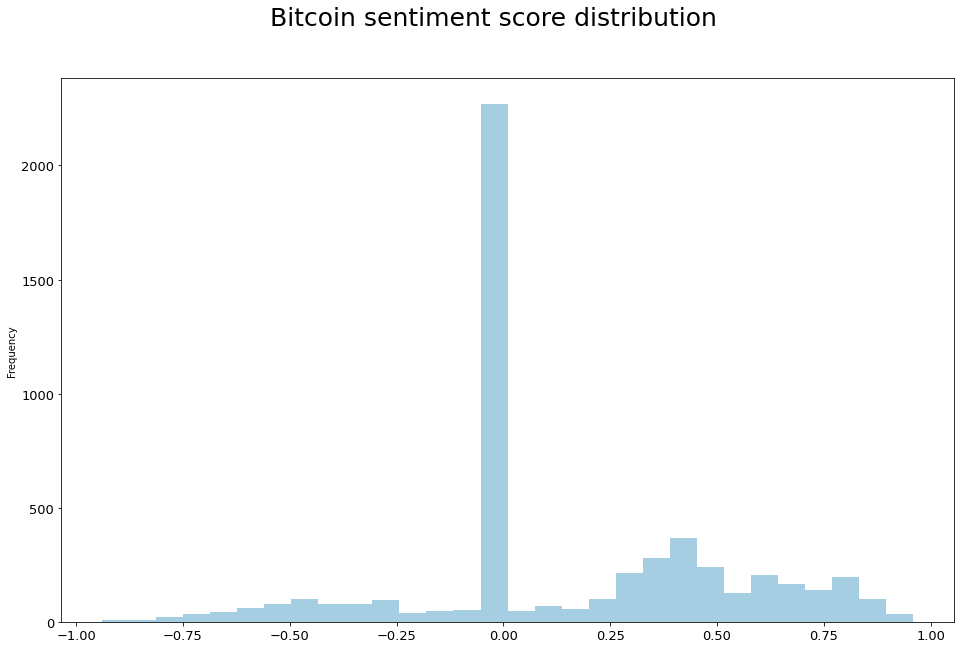

In [8]:
df[df['symbol'] == 'LTC'].sentiment_score.plot.hist(bins = 30)
plt.suptitle('Bitcoin sentiment score distribution', fontsize=25);

## Analyzing top retweets

Let's quickly check the most retweeted comments regarding crypto and see what they talk about:

In [9]:
df.sort_values('retweet_count', ascending = False)['tweet'].head(10)

117655    I'm giving away a DOGE Tesla &amp; $50,000 in ...
136094    I'm giving away a DOGE Tesla &amp; $50,000 in ...
100964    🎃 MY BIGGEST GIVEAWAY YET 🎃\n\n A Mutant Ape f...
101044    Giving away $1,000 of Ethereum $ETH 🚀\n\nAll y...
130166    Full #Bitcoin, 5 $ETH, 4,000 $ADA Giveaway.\n\...
101570    Full #Bitcoin, 5 $ETH, 4,000 $ADA Giveaway.\n\...
39295     Full #Bitcoin, 5 $ETH, 4,000 $ADA Giveaway.\n\...
100959    🎉 GIVEAWAY TIME 🎉\n\n1 JRNY NFT (2.25 ETH Floo...
100951    I’ll give this @JRNYclub pass (currently worth...
133272    If you’d like to help develop Doge, please sub...
Name: tweet, dtype: object

Interestingly enough, most of them seem to be related to **givaways** (raffles). We will set an arbitrary number of minimum retweets (let's say min. 15,000) and analyze with regex the number of tweets with the stem "giv" from "give" or "giveaway".

In [10]:
# Set a minimum of 15,000 retweets and sorting them in descending order
top_tweets = df[df['retweet_count'] >= 15000].sort_values('retweet_count', ascending = False)[['tweet']]

# Establishing a count variable
count = 0

for tweet in top_tweets.tweet:
    
    # Write the regex norm
    r = re.compile('giv')
    
    # Search for the norm in the tweet
    l = re.search(r, tweet.lower())
    
    if l:
        count += 1

print(count/len(top_tweets.tweet))

0.75


75% of tweets with top retweets, or 15 out of 20, have to do with free raffles. This relationship with givaways, although interesting, **does not** affect the way we see and treat these tweets. Actually, it poses the new doubt of whether these sort of events have an impact on crypto prices too. 